<center>
<img src="logo.png" height="900"> 
</center>


# Байесовская домашка

В этом задании мы оценим несколько простых моделей с помощью `pymc3`. 

Задачи делались [на основе книги Байесовские методы для хакеров.](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) В ней вы можете найти ещё больше примеров использования байесовских методов с помощью pymc3. 

In [1]:
import numpy as np
import pandas as pd

from scipy import stats as sts

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
import pymc as pm #использовал pymc - новую версию, поддерживаемую Python 3.13
pm.__version__

'5.22.0'

# Упражнение 1 (Маша и медведи)

Помните задачку с вынюхиванием из лекции? Давайте начнём с того, что попробуем решить её в `pymc3`.

__Модель медведя:__ $y_i \sim N(m, 2^2)$

__Априорное мнение, где спряталась Маша:__ $m \sim N(1, 4^2)$

In [5]:
y = np.array([0.5, -1]) # медведи

Задайте априорное распределение и нашу модель.

Initializing NUTS using jitter+adapt_diag...


MAP оценка: -0.1111


Sequential sampling (2 chains in 1 job)
NUTS: [m]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


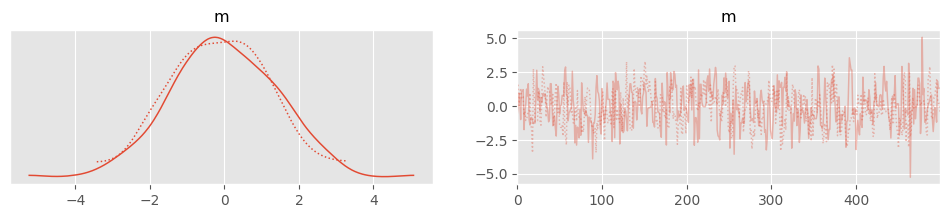

Вероятность P(m < 0): 0.5250


In [8]:
import arviz as az

# Создание модели
basic_model = pm.Model()

with pm.Model() as basic_model:
    # Априорное распределение для m
    m = pm.Normal('m', mu=1, sigma=4)
    
    # Правдоподобие наблюдений
    y_obs = pm.Normal('y_obs', mu=m, sigma=2, observed=y)
    
    # Нахождение MAP оценки
    map_estimate = pm.find_MAP()
    print(f"MAP оценка: {map_estimate['m']:.4f}")
    
    # MCMC sampling с возвратом InferenceData
    trace = pm.sample(500, tune=500, cores=1, return_inferencedata=True)
    
    # Визуализация цепей
    az.plot_trace(trace)
    plt.show()
    
    # Расчет P(m < 0)
    ans_prob = np.mean(trace.posterior['m'].values < 0)
    print(f"Вероятность P(m < 0): {ans_prob:.4f}")

Найдите моду апостериорного распределения (байесовские методы для бедных). Запишите результат в переменную `map_estimate`.

In [9]:
assert np.abs(float(map_estimate['m']) + 0.111111) < 1e-4

# несколько похожих скрытых тестов

Обучите модельс с помощью MCMC, 500 итераций для обучения будет достаточно. 

Initializing NUTS using jitter+adapt_diag...


MAP оценка: -0.1111


Sequential sampling (2 chains in 1 job)
NUTS: [m]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


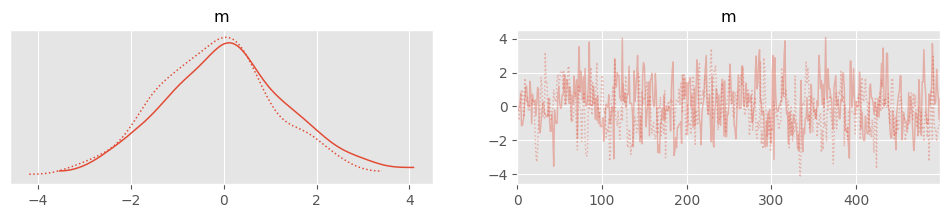

Вероятность P(m < 0): 0.5110


In [10]:
with pm.Model() as basic_model:
    # Априорное распределение для m
    m = pm.Normal('m', mu=1, sigma=4)
    
    # Правдоподобие наблюдений
    y_obs = pm.Normal('y_obs', mu=m, sigma=2, observed=y)
    
    # Нахождение MAP оценки
    map_estimate = pm.find_MAP()
    print(f"MAP оценка: {map_estimate['m']:.4f}")
    
    # MCMC sampling с возвратом InferenceData
    trace = pm.sample(500, tune=500, cores=1, return_inferencedata=True)
    
    # Визуализация цепей
    az.plot_trace(trace)
    plt.show()
    
    # Расчет P(m < 0)
    ans_prob = np.mean(trace.posterior['m'].values < 0)
    print(f"Вероятность P(m < 0): {ans_prob:.4f}")

Посмотрите на визуализацию Марковских цепей. Правда ли, что цепь сошлась?

Нет, цепь не сошлась

Найдите вероятность $P(m < 0)$. Ответ запишите в переменную `ans_prob`.

In [11]:
assert ans_prob > 0.5

# несколько похожих скрытых тестов

# Упражнение 2 (Челленджер)

Байесовский подход - это просто другой способ оценивать те же самые модели. Например, давайте попробуем оценить логистическую регрессию. 

$28$ января $1986$ года космический шатл «Челленджер» взорвался при взлёте. Семь астронавтов, находившихся на борту, погибли. В ходе расследования причин катастрофы основной версией была неполадка с резиновыми уплотнительными кольцами в соединении с ракетными ускорителями. Для $23$ предшествовавших катастрофе полётов «Челленджера» известны температура воздуха и появление повреждений хотя бы у одного из уплотнительных колец.

In [23]:
df = pd.read_csv('./data/challenger.csv', sep='\t')
print(df.shape)
df.head()

(23, 3)


,Unnamed: 0,Temperature,Incident
0,Apr12.81,18.9,0
1,Nov12.81,21.1,1
2,Mar22.82,20.6,0
3,Nov11.82,20.0,0
4,Apr04.83,19.4,0


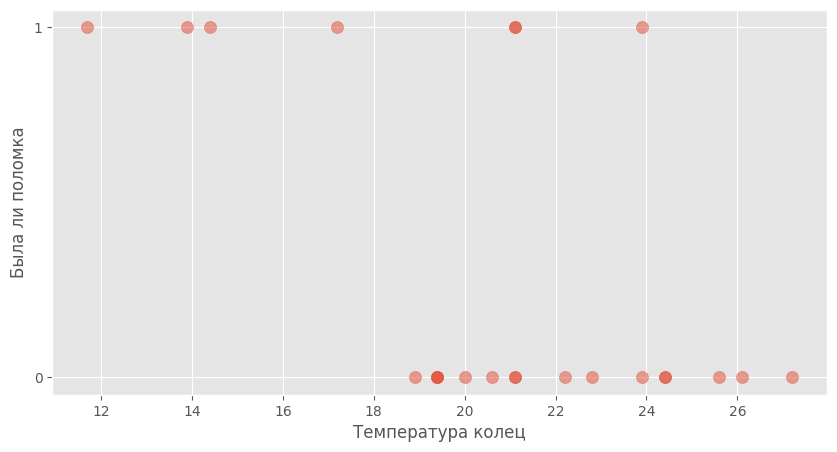

In [24]:
t = df.Temperature.values
y = df.Incident.values

plt.figure(figsize=(10, 5))
plt.scatter(t, y, s=75, alpha=0.5)
plt.yticks([0, 1])

plt.ylabel("Была ли поломка")
plt.xlabel("Температура колец");


Обучим Байесовскую версию логистичесской регресcии.  Модель буде выглядеть следующим образом: 

\begin{equation*}
\begin{aligned}
& \beta \sim N(0, 10^2) \\
& \alpha \sim N(0, 10^2) \\
& p \sim Bern(p) \\
& p = P(y = 1) = \frac{1}{1 + e^{\alpha + \beta \cdot t}}
\end{aligned}
\end{equation*}

In [25]:
import pytensor.tensor as pt

t = df.Temperature.values
y = df.Incident.values

# Байесовская логистическая регрессия
with pm.Model() as model:
    # Априорные распределения
    beta = pm.Normal('beta', mu=0, sigma=10)
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    
    # Логистическая функция
    p = pm.Deterministic('p', 1.0/(1. + pt.exp(beta*t + alpha)))
    
    # Правдоподобие
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y)
    
    # MAP оценка
    map_estimate = pm.find_MAP()
    print(f"MAP оценки: alpha={map_estimate['alpha']:.4f}, beta={map_estimate['beta']:.4f}")
    

MAP оценки: alpha=-6.6537, beta=0.3710


Найдите моду апостериорного распределения (байесовские методы для бедных). Запишите результат в переменную `map_estimate`.

In [26]:
assert np.abs(float(map_estimate['beta']) - 0.1665) < 1e-2

# несколько похожих скрытых тестов

AssertionError: 

Попробуем обучить модель немного по-новому. В переменной `step` запишемм конкретный алгоритм, который будем использовать при обучении. В `pm.sapmple` укажем из какой точке надо стартовать алгоритму. В качестве стартовой точки укажем моду апостериорного распределения, полученную в предыдущем пункте. 

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 2 chains for 1_000 tune and 12_000 draw iterations (2_000 + 24_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


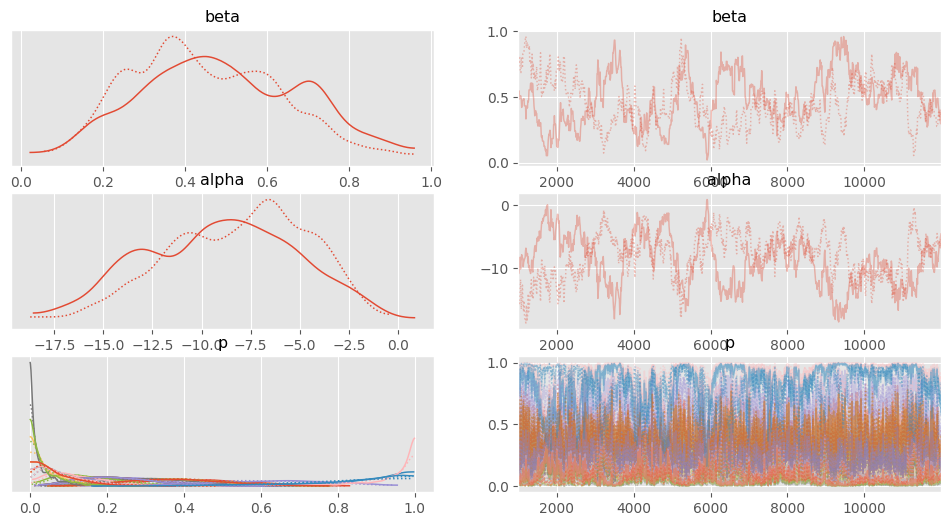

Вероятность что beta < 0.0001: 0.000000


In [28]:
# Данные
t = df.Temperature.values
y = df.Incident.values

with pm.Model() as model:
    # Априорные распределения
    beta = pm.Normal('beta', mu=0, sigma=10)
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    
    # Логистическая функция
    p = pm.Deterministic('p', 1.0/(1. + pm.math.exp(beta*t + alpha)))
    
    # Правдоподобие
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y)
    
    # Находим MAP оценку
    map_estimate = pm.find_MAP()
    
    # Настраиваем MCMC
    step = pm.Metropolis()
    
    # Запускаем сэмплирование с возвратом InferenceData
    trace = pm.sample(
        draws=12000,  # Уменьшили для скорости
        step=step, 
        start=map_estimate, 
        tune=1000, 
        cores=1,
        return_inferencedata=True  # Возвращаем InferenceData
    )
    
    # Прореживание и удаление прогрева
    burned_trace = trace.sel(draw=slice(1000, None, 10))
    
    # Визуализация цепей
    az.plot_trace(burned_trace)
    plt.show()
    
    # Вычисляем P(beta < 0.0001)
    prob_beta = float((burned_trace.posterior['beta'] < 0.0001).mean())
    print(f"Вероятность что beta < 0.0001: {prob_beta:.6f}")

Посмотрим, сошлись ли цепи.

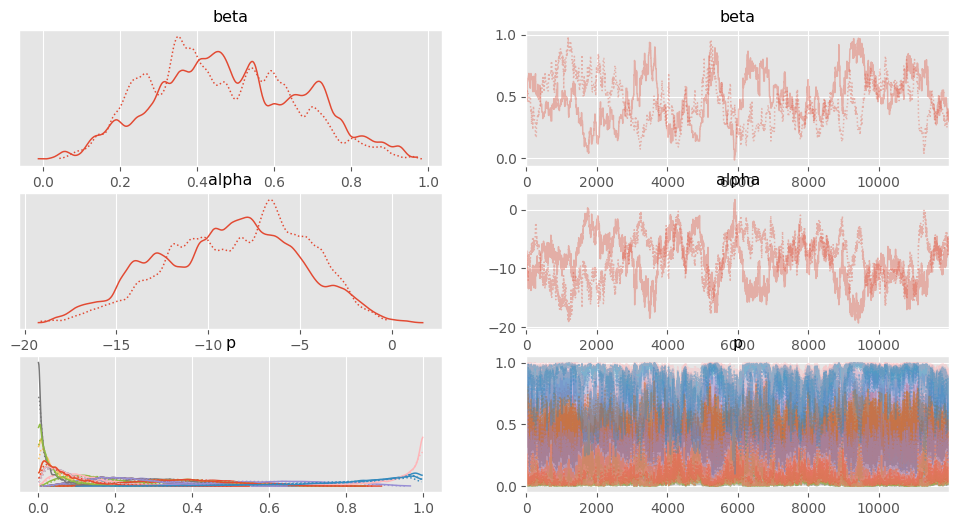

In [29]:
az.plot_trace(trace);

Какова вероятность того, что $\beta < 0.0001$? То есть, какова вероятность того, что между температурой и вероятностью поломки нет связи? Запишите овтет в переменную `prob_beta`.

In [30]:
assert prob_beta < 0.1

# несколько похожих скрытых тестов

Нарисуем Получившиеся результаты. Для каждой температуры найдем $95\%$ байесовский интервал для вероятности того, что катастрофа произойдёт.

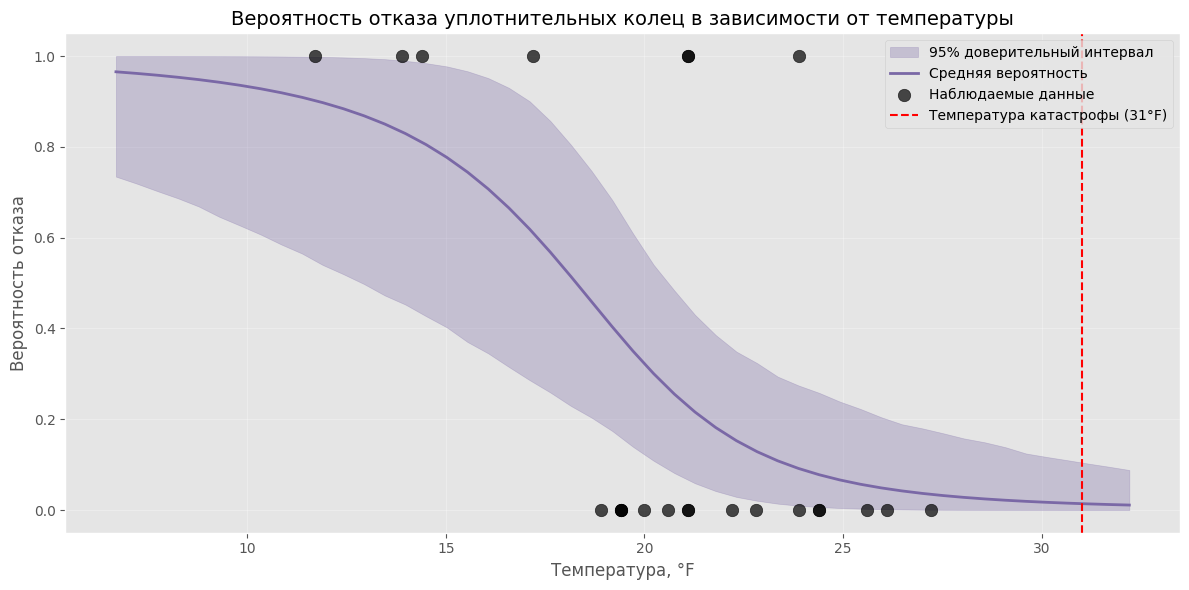

In [36]:
from scipy.stats.mstats import mquantiles
import numpy as np
import matplotlib.pyplot as plt

def logistic(x, beta, alpha):
    """Логистическая функция для предсказания вероятности"""
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

# Создаем последовательность температур для предсказания
t_seq = np.linspace(t.min() - 5, t.max() + 5, 50)[:, None]

# Получаем параметры из сэмплов
beta_samples = burned_trace.posterior['beta'].values.flatten()
alpha_samples = burned_trace.posterior['alpha'].values.flatten()

# Вычисляем вероятности для каждой температуры
p_seq = logistic(t_seq.T, beta_samples[:, None], alpha_samples[:, None])

# Вычисляем статистики
mean_prob_t = p_seq.mean(axis=0)
qs = mquantiles(p_seq, [0.025, 0.975], axis=0)

# Визуализация
plt.figure(figsize=(12, 6))
plt.fill_between(t_seq[:, 0], *qs, alpha=0.3, color="#7A68A6", label="95% доверительный интервал")
plt.plot(t_seq[:, 0], mean_prob_t, lw=2, color="#7A68A6", label="Средняя вероятность")
plt.scatter(t, y, color="k", s=80, alpha=0.7, label="Наблюдаемые данные")

# Отметим температуру катастрофы (31°F)
plt.axvline(x=31, color='r', linestyle='--', label='Температура катастрофы (31°F)')

plt.xlabel("Температура, °F", fontsize=12)
plt.ylabel("Вероятность отказа", fontsize=12)
plt.title("Вероятность отказа уплотнительных колец в зависимости от температуры", fontsize=14)
plt.legend(loc="upper right", frameon=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

В день катастрофы температура уплотнителя была $31$ градус по Фарингейту. Найдите апостерионое распределение  вероятности катастрофы. 

In [37]:
# Вычисляем вероятность отказа при 31°F для всех сэмплов
disaster_temp = 31
p_disaster = 1.0 / (1.0 + np.exp(
    burned_trace.posterior['beta'].values.flatten() * disaster_temp + 
    burned_trace.posterior['alpha'].values.flatten()
))

# Вычисляем статистики


Найдите $5\%$ квантиль, математическое ожидание и $95\%$ квантиль апостериорного распределения. Заишите их в соответствующие переменные. Что это означает в контексте прогноза катастрофы? 

In [39]:
q05 = np.quantile(p_disaster, 0.05)  # 5% квантиль
avg = np.mean(p_disaster)            # Математическое ожидание
q95 = np.quantile(p_disaster, 0.95)  # 95% квантиль

q05

np.float64(5.984327061596432e-05)

In [35]:
assert q05  > 0.8

# несколько похожих скрытых тестов

AssertionError: 